In [1]:
import sys
print(sys.executable) 

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11


### Mushroom Edibility Project Description
The purpose of this project is to create a model that can accurately determine whether a mushroom is edible or poisonous, based on the various physical features of the mushroom. Somewhat inspired by a recent news article I read where a family went to the hospital because they bought a gen-AI mushroom guide book that gave them incorrect info... I figure these models can do better than that.

This will be a binary classification task (edible/poisonous) with multiple features, and will try out various model types (Logistic Regression, k-Nearest Neighbors, Decision Trees (Single Tree, Random Forest, Gradient), and SVMs.

The data is sourced from a public dataset at https://archive.ics.uci.edu/dataset/73/mushroom. The data was obtained in 1987 from various samples of 23 species of gilled mushrooms in the Agaricus and Lepiota Families.

Citation: Mushroom. (1987). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import arff
import time
from sklearn.model_selection import GridSearchCV

### **Step 1**: Importing mushroom csv data
The raw data is tabulated in a CSV file, with 23 total features, and 8124 samples. All the features are categorical (some of which are binary, some which have multiple categories). Most of them refer to physical features (such as stalk/cap/ring/veil shape/texture/color), although there's a few other misc features like odor, habitat, population. The last column is whether or not the mushroom is edible or poisonous (the result we'll be predicting).

In [3]:
# Dataset source: https://archive.ics.uci.edu/dataset/73/mushroom
dfm = pd.read_csv('mushroom_data.csv')
print(dfm.info())

dfm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


### **Step 2**: Data Cleaning
Data set is relatively clean, but there's a few notable steps still.
1. The stalk-root column has some missing data, so filter out rows with empty cells first.
2. When checking the heatmap, I noticed that only 1 value in the veil-type column is actually present after cleaning up the stalk-root column, so I got rid of the feature. Not sure if this implies some correlation between veil-type and stalk-root either, but it could just be an issue with how the data was collected. There might be an argument for removing the stalk-root column and keeping veil-type instead, but stalk-root seems more universal.
3. Converted the poisonous column (the test set) from an object type to int (0/1 for binary classification).

In [4]:
#stalk-root column has some missing data, remove those rows
dfm = dfm.dropna(subset=['stalk-root'])
print("Number of rows: " + str(dfm.shape[0]))

# Every row after removing invalid stalk-roots has the same veil-type, so column is redundant
# dfv = dfm.loc[dfm['veil-type'] == 'u']
# print(dfv.shape[0]) #length equals 0
dfm = dfm.drop(['veil-type'], axis=1)

# Convert poisonous from string to integer for easier modeling (0 = edible, 1 = poisonous)
# Not sure if actually needed, but can't hurt
if 'poisonous' in dfm:
    dfm['poisonous_n'] = dfm.poisonous.apply(lambda x: 0 if x == 'e' else 1)
    dfm = dfm.drop(['poisonous'], axis=1)

# Works, but throws a warning due to changing column type from string to int
# dfm['poisonous'] = dfm['poisonous'].replace('e', 0)
# dfm['poisonous'] = dfm['poisonous'].replace('p', 1)

dfm.info()

Number of rows: 5644
<class 'pandas.core.frame.DataFrame'>
Index: 5644 entries, 0 to 8114
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 5644 non-null   object
 1   cap-surface               5644 non-null   object
 2   cap-color                 5644 non-null   object
 3   bruises                   5644 non-null   object
 4   odor                      5644 non-null   object
 5   gill-attachment           5644 non-null   object
 6   gill-spacing              5644 non-null   object
 7   gill-size                 5644 non-null   object
 8   gill-color                5644 non-null   object
 9   stalk-shape               5644 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  5644 non-null   object
 12  stalk-surface-below-ring  5644 non-null   object
 13  stalk-color-above-ring    5644 non-null   object
 14  stalk-co

### **Step 3**: Checking for correlated features
Started by plotting the correlation matrix. Values need to be normalized into ints first since all the features are categorical/objects.

In [5]:
# Correlation matrix, Factorizing due to non-numerical data types
dfm_cor = dfm.apply(lambda x: x.factorize()[0]).corr()
dfm_cor

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous_n
cap-shape,1.000000,0.061266,0.006390,0.024314,0.031966,0.036518,0.012686,0.045297,0.060692,0.079150,...,0.066042,0.081847,0.094223,0.047866,0.071161,0.076913,0.103736,0.128877,0.030009,-0.012738
cap-surface,0.061266,1.000000,-0.018024,0.170464,0.231799,-0.011919,-0.079934,0.079547,0.078234,0.052305,...,0.184989,0.311082,0.294905,-0.007939,-0.098754,0.204256,0.001669,0.387680,0.328787,0.068231
cap-color,0.006390,-0.018024,1.000000,-0.037622,0.289324,0.057650,-0.058742,0.031560,0.141792,0.116227,...,-0.073184,0.019587,0.042405,-0.026314,0.158058,-0.041243,0.166598,0.099936,0.085354,-0.121709
bruises,0.024314,0.170464,-0.037622,1.000000,0.559444,0.064351,0.439183,-0.040178,-0.036862,-0.348294,...,0.643622,0.416310,0.382574,0.042863,0.007218,0.830229,0.409097,0.007056,-0.061334,-0.435562
odor,0.031966,0.231799,0.289324,0.559444,1.000000,0.151638,0.011745,0.261129,0.264612,0.028335,...,0.454124,0.502011,0.451342,-0.000648,0.158408,0.530517,0.492609,0.353483,0.280530,-0.415438
gill-attachment,0.036518,-0.011919,0.057650,0.064351,0.151638,1.000000,-0.026630,0.021353,0.095599,-0.057738,...,0.050650,0.163367,0.164673,-0.002131,0.520652,0.157052,0.150416,0.093391,0.036296,-0.071945
gill-spacing,0.012686,-0.079934,-0.058742,0.439183,0.011745,-0.026630,1.000000,-0.178484,-0.148132,0.314060,...,-0.173242,-0.342702,-0.264082,0.080026,-0.074985,0.099214,-0.175159,-0.378184,-0.228317,0.264160
gill-size,0.045297,0.079547,0.031560,-0.040178,0.261129,0.021353,-0.178484,1.000000,0.115416,0.282368,...,0.246351,0.268924,0.182452,-0.099801,0.060127,0.240390,0.093165,0.105979,0.109261,0.215289
gill-color,0.060692,0.078234,0.141792,-0.036862,0.264612,0.095599,-0.148132,0.115416,1.000000,0.088911,...,0.093794,0.197613,0.202523,0.063676,0.167014,0.065731,0.221718,0.257183,0.212575,-0.129357
stalk-shape,0.079150,0.052305,0.116227,-0.348294,0.028335,-0.057738,0.314060,0.282368,0.088911,1.000000,...,-0.563249,-0.330838,-0.300655,-0.038458,-0.162582,-0.426768,-0.448541,0.031050,-0.000168,0.592446


##### Plotting out the heatmap, for easier readability.

<Axes: >

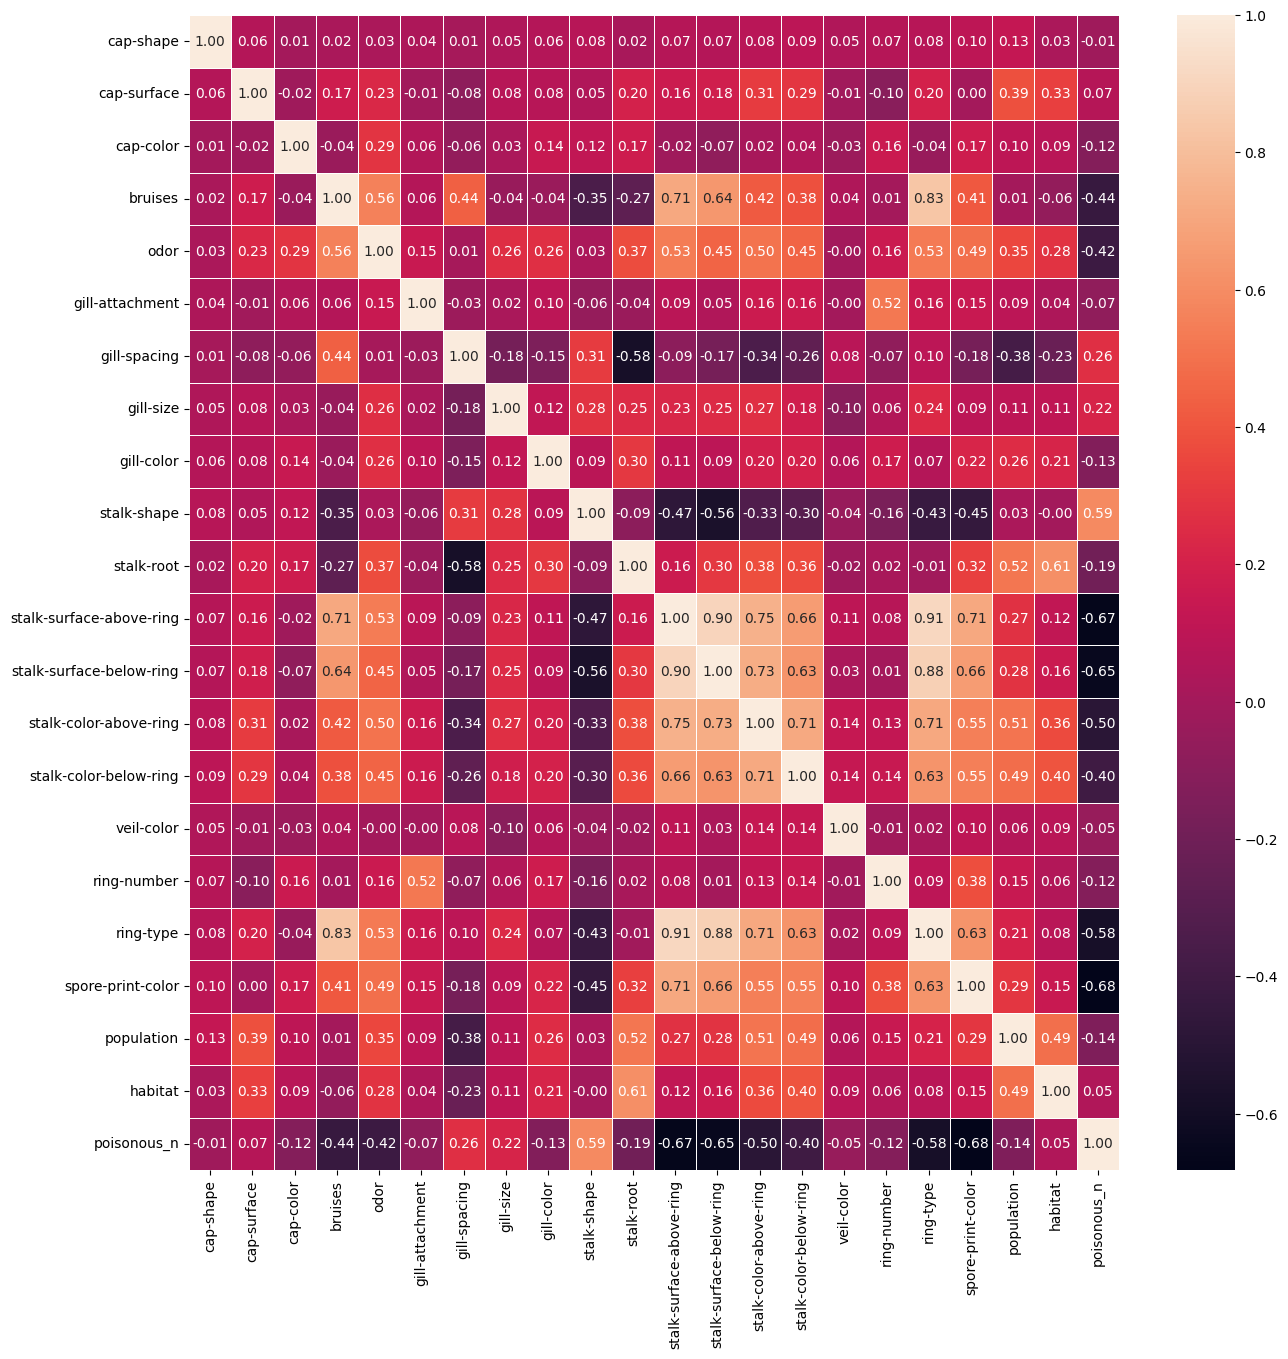

In [6]:
#Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(dfm_cor, linewidths=.5, annot=True, fmt=".2f")

# Not too many correlations, notable ones:
# The stalk-related columns are correlated, also correlated with ring-type
# Possible correlation between ring-type and bruises as well

# Not much individual correlation with poisonous, closest is stalk-shape

##### Pairplot doesn't really show much, probably not too useful for categorical features honestly since there's not really any collinearity.

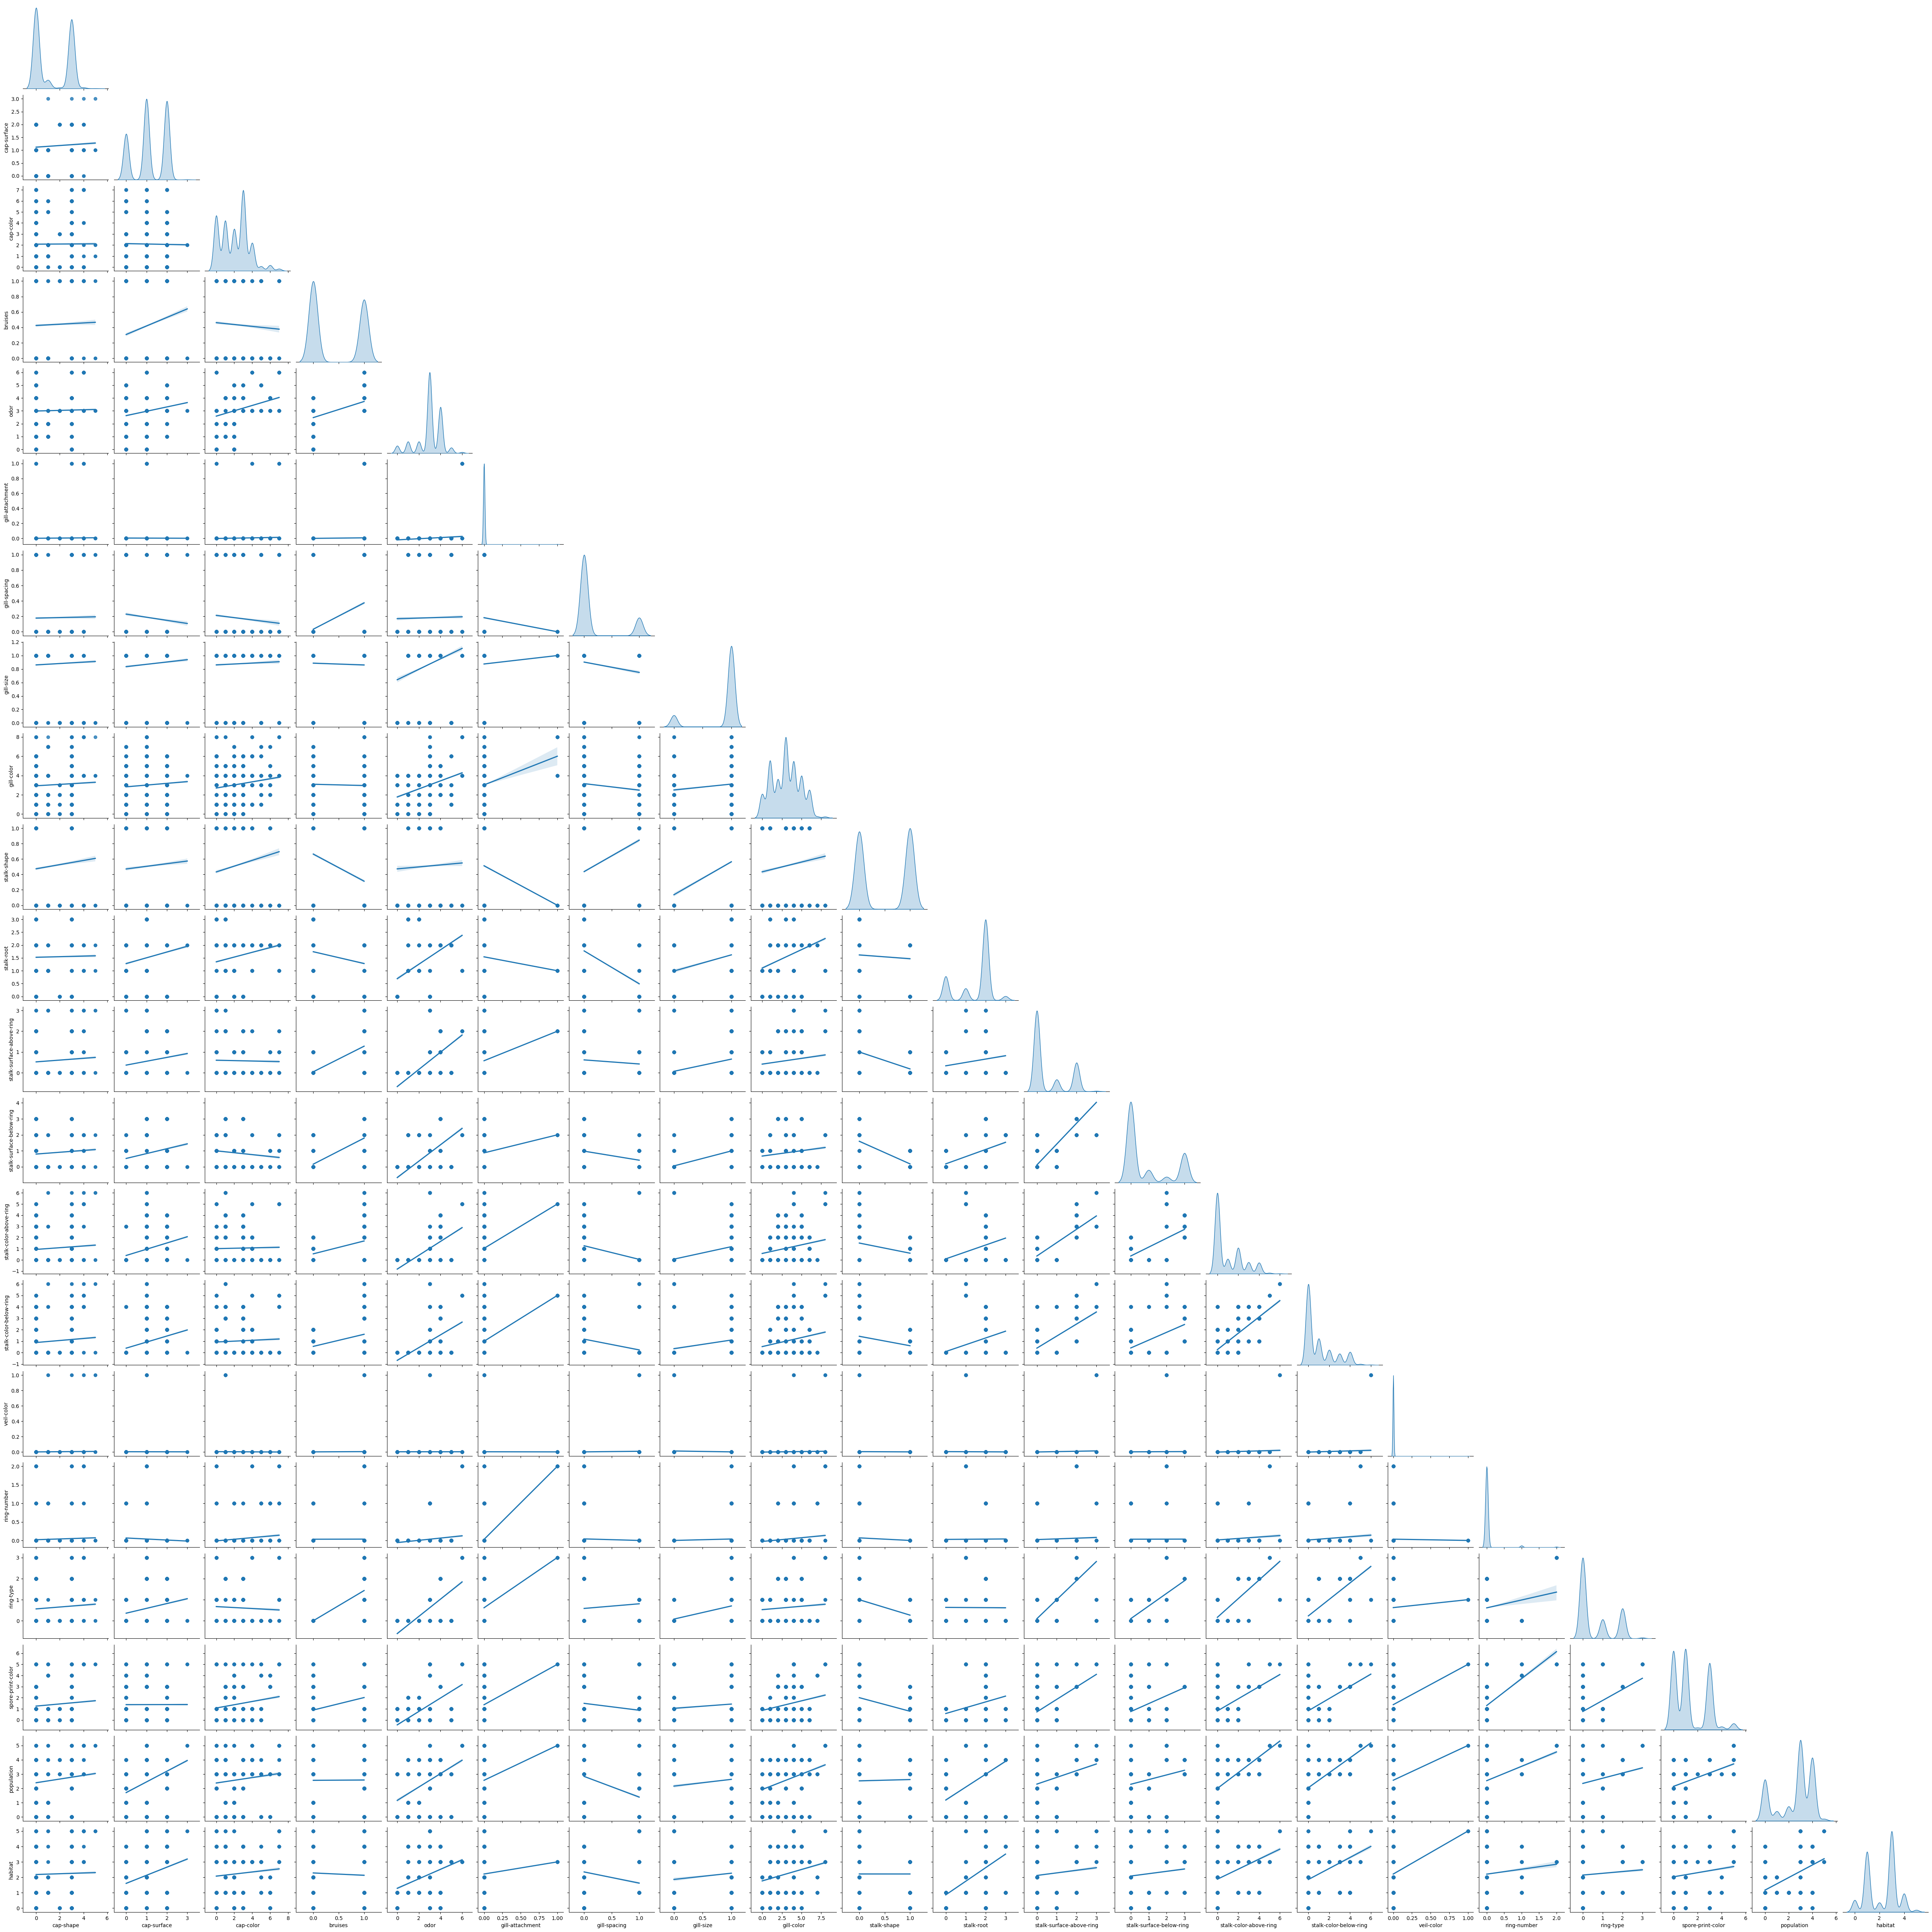

In [7]:
#Pairplot
sns.pairplot(dfm.apply(lambda x: x.factorize()[0]), vars = dfm.columns[0:21], kind='reg', diag_kind='kde', corner=True, dropna=True)

##### **Quick Conclusions**:
There's not too much correlation between individual features, but there's a few notable ones still.
1. The stalk related columns (stalk-color and stalk-surface) are somewhat correlated unsurprisingly, along with the ring-type feature.
2. Bruises and ring-type also might have some correlation.
3. The poisonous column doesn't have any strong correlations with any one feature, so whatever model is used will need to use multiple features.

### **Step 4**: Data splitting
Total row count is 5644 rows, which is relatively large. I originally started with an 80:20 training/test split, which worked...a bit too well.

As it turns out, there seems to be very strong correlation between the features and the mushroom's edibility, which is good for my models. But it unfortunately doesn't tell me much about the quality of the models because almost all of them were hitting 100% accuracy with the 80:20 split. This could indicate some sort of bias within the dataset itself, so I lowered the training size to a very small number (tested 2-5% of the data, ~100-300 samples), both to counteract this potential bias, and just so I can actually compare the models (they all still perform very well, but the differences start to show).

In [8]:
# Testing out different models
# Binary Classification problem, so potential models: Logisic Regression, Decision Trees (single, RF), SVM

# Splitting the data
# All categorical features
# 5644 total samples, need to figure out how to split
X = dfm.apply(lambda x: x.factorize()[0]).iloc[:, 0:-1]
y = dfm.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=32)

print("Training set size: " + str(len(X_train)))
print("Test set size: " + str(len(X_test)))

# print(X_train)
# print(y_train)

Training set size: 282
Test set size: 5362


### **Step 5**: Modeling
This is a binary classification problem (a mushroom is either edible (0) or poisonous (1)). So potential models I'll test out include: Logistic Regression, Decision Trees (Single Tree, Random Forest, Gradient), kNN, and SVMs. I will primarily be using accuracy as the primary metric, since the baseline level of accuracy is already so high and a theoretical perfect model is achievable with sufficient training data, I want the models to focus on getting as close as possible to being perfect.

In [9]:
# Storing accuracy scores of models for comparison
scores = {}

#### **A. Logistic Regression**

[[ 0.01068451 -1.37080625  0.31299298 -1.27500012  0.50706857  0.
  -1.05926992 -3.10664555  0.02566445 -1.29281562  0.14872484  0.65955301
   0.93298562  0.67113804 -0.41260733  0.         -0.74754129  1.15676198
   0.72367183  0.07714742 -0.84654335]]
Train Score: 0.9716312056737588
Test Score: 0.9464751958224543
Training Time: 0.0011777877807617188s


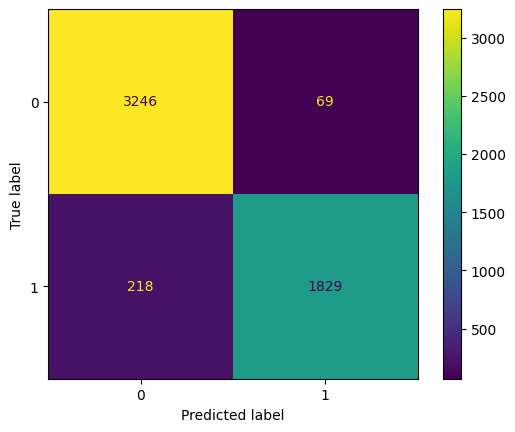

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

start = time.time()
lr_clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
stop = time.time()

print(lr_clf.coef_)
scores['LR'] = lr_clf.score(X_test, y_test)

print("Train Score: " + str(lr_clf.score(X_train, y_train)))
print("Test Score: " + str(scores['LR']))
print("Training Time: " + str(stop - start) + "s")

y_lr_test_pred = lr_clf.predict(X_test)

lr_cm = confusion_matrix(y_test, y_lr_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
cm_disp.plot()
plt.show()

##### Plotting the ROC curve:

Text(0.7, 0.2, 'AUC=0.987')

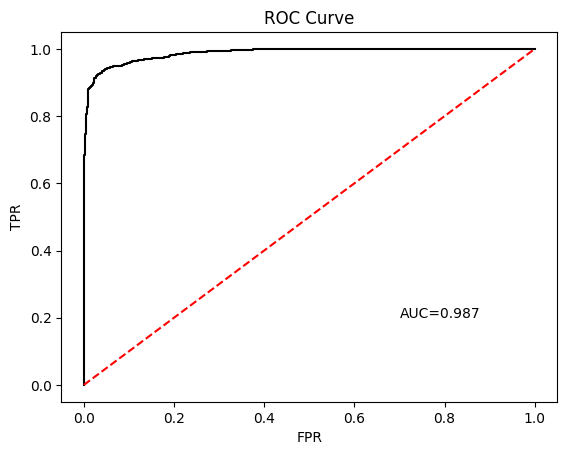

In [11]:
# Probabilities
y_test_pred_p = lr_clf.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_test_pred_p[:, 1])
auc_score = roc_auc_score(y_test, y_test_pred_p[:, 1])

# print(fpr)
# print(tpr)

plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC='+"{:.3f}".format(auc_score))

#### Logistic Regression Conclusions:
The worst performing of the models, as somewhat expected due to how simple it is. It still performs pretty well overall, with accuracy hovering between .94-.96, and a fairly large area under the ROC curve.

### B. k-Nearest Neighbors

Train Score: 0.9858156028368794
Test Score: 0.9675494218575158


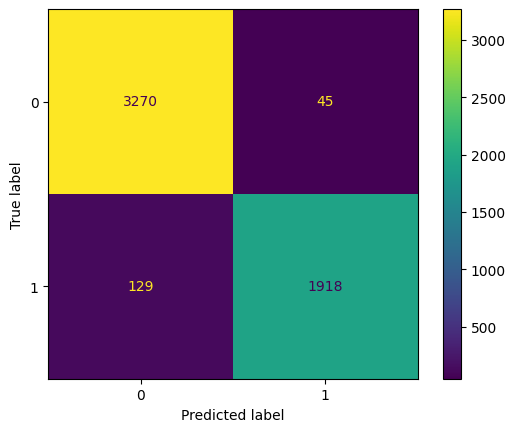

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3, algorithm='auto').fit(X_train, y_train)

scores['kNN'] = knn_clf.score(X_test, y_test)

print("Train Score: " + str(knn_clf.score(X_train, y_train)))
print("Test Score: " + str(scores['kNN']))

# Confusion Matrix
y_knn_test_pred = knn_clf.predict(X_test)

knn_cm = confusion_matrix(y_test, y_knn_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
cm_disp.plot()
plt.show()

#### kNN Conclusions
The 2nd worst performing of the models score-wise, but still fairly strong. Works best with a low number of neighbors (just manually tested neighbors [1,3,5,7,9]), this model likely performs poorly due to the lack of training data. I assume due to the low sample count, the distances to the nearest neighbor is going to be much higher and therefore more likely to classify incorrectly.

### C. Decision Trees

Starting with a single decision tree:

Train Score: 1.0
Test Score: 0.9940320775829914


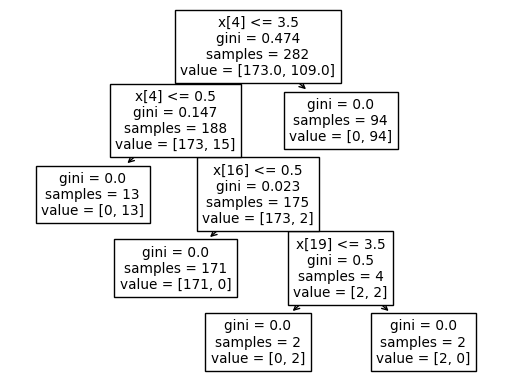

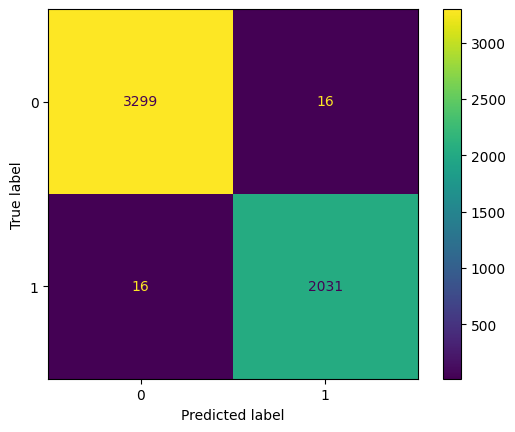

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Single Decision Tree
sdt_clf = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)
plot_tree(sdt_clf)


scores['SDT'] = sdt_clf.score(X_test, y_test)
print("Train Score: " + str(sdt_clf.score(X_train, y_train)))
print("Test Score: " + str(scores['SDT']))

#Try GridSearchCV for params
y_sdt_test_pred = sdt_clf.predict(X_test)

sdt_cm = confusion_matrix(y_test, y_sdt_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=sdt_cm)
cm_disp.plot()
plt.show()

Trying Random Forest:

Train Score: 1.0
Test Score: 0.9958970533383066


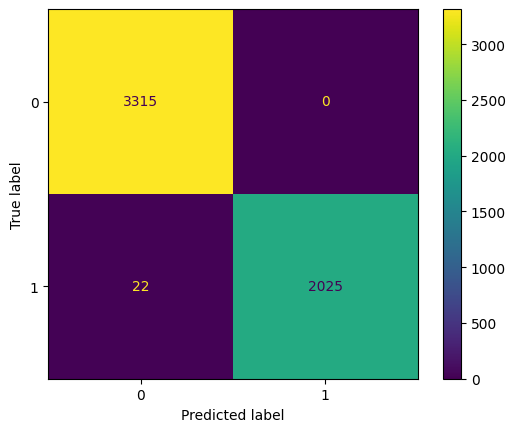

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)

scores['RF'] = rf_clf.score(X_test, y_test)
print("Train Score: " + str(rf_clf.score(X_train, y_train)))
print("Test Score: " + str(scores['RF']))

y_rf_test_pred = rf_clf.predict(X_test)

rf_cm = confusion_matrix(y_test, y_rf_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm)
cm_disp.plot()
plt.show()

Trying Gradient Boosting Machines:

Train Score: 1.0
Test Score: 0.990302126072361
Best Score: 0.9929078014184397
Best Params: {'learning_rate': 0.1, 'n_estimators': 80}


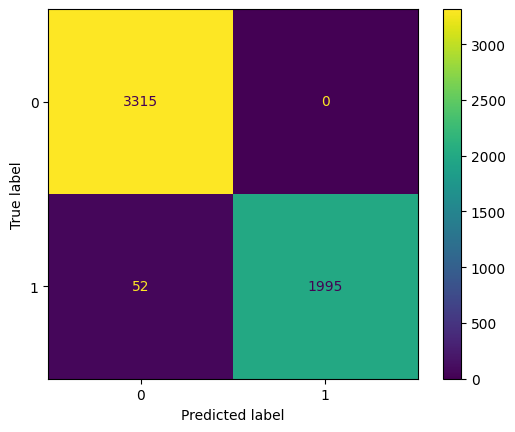

In [15]:
# GBM
from sklearn.ensemble import GradientBoostingClassifier

gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1], 'n_estimators': [10 * i for i in range(1, 20)]}
# GridSearchCV(
# gbm_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50).fit(X_train, y_train)
gbm_clf = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gbm_param_grid, cv = 3, scoring = 'accuracy').fit(X_train, y_train)

scores['GBM'] = gbm_clf.best_estimator_.score(X_test, y_test)
print("Train Score: " + str(gbm_clf.best_estimator_.score(X_train, y_train)))
print("Test Score: " + str(scores['GBM']))

print("Best Score: " + str(gbm_clf.best_score_))
print("Best Params: " + str(gbm_clf.best_params_))

y_gbm_test_pred = gbm_clf.predict(X_test)

gbm_cm = confusion_matrix(y_test, y_gbm_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=gbm_cm)
cm_disp.plot()
plt.show()

#### Decision Tree Conclusions:
Probably the most consistent of the models, even at very low count test sets, it maintains a high accuracy count. In general, ensembling does have an accuracy boost compared to the single decision tree as well, although there are sometimes exceptions (Random Forest was almost always the strongest, but there were certain data splits where Gradient Boosting and the plain Decision tree were comparable.

The Single Decision Tree is notably not too deep even with default values. Might indicate that a lot of features don't really mean much individually.

For Random Forest, I tried a few different values (different increments of 10, running multiple runs due to the random nature of the model) for the number of estimators/trees created. n = 50 seemed like the sweet spot. Below 50, RF could be inconsistent, sometimes generating some relatively poor performing estimates, and above 50, there wasn't really a noticeable improvement in accuracy, so it's not really worth the extra performance cost.

With Gradient Boosting, I used GridSearchVN on the learning rate and n_estimators. n around 60-80 seemed to be the best spot, learning rate worked best at the default of 0.1 with the 5% training set size (with the 2% training set size, it prefers a lower learning rate and higher n). Compared to RF, on average it performs worse, but it's more consistent since it's not random.

### D. SVM

[0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
Train Score: 1.0
Test Score: 0.9979485266691533
Best Score: 0.9858156028368793
Best Params: {'C': 8, 'kernel': 'rbf'}


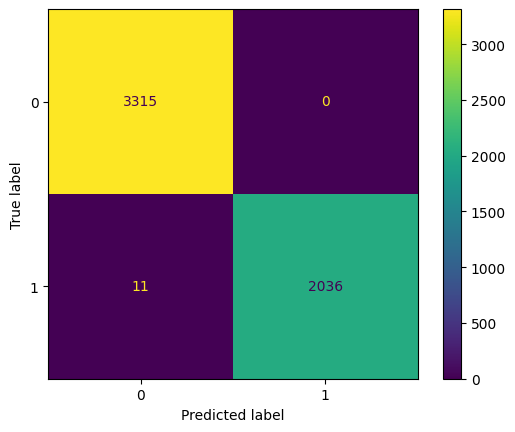

In [16]:
# SVM
from sklearn.svm import SVC
log_range = [2**i for i in range(-5, 6)]
print(log_range)
svm_param_grid = {'C': log_range, 'kernel': ['rbf', 'poly']}
svm_clf = GridSearchCV(estimator=SVC(), param_grid=svm_param_grid, cv = 3, scoring = 'accuracy').fit(X_train, y_train)
# svm_clf = SVC(C=3, kernel='rbf').fit(X_train, y_train)

scores['SVM'] = svm_clf.best_estimator_.score(X_test, y_test)
print("Train Score: " + str(svm_clf.best_estimator_.score(X_train, y_train)))
print("Test Score: " + str(scores['SVM']))
print("Best Score: " + str(svm_clf.best_score_))
print("Best Params: " + str(svm_clf.best_params_))

y_svm_test_pred = svm_clf.predict(X_test)

svm_cm = confusion_matrix(y_test, y_svm_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
cm_disp.plot()
plt.show()

#### SVM Conclusions:

With the 5% trainings set size, SVM is the strongest performer of the models. The C parameter does need to be tuned a bit (C=1 performs relatively poorly, C=2 or 3 seemed to be around the inflection point, GridSearchCV seems to think C=8 is the best spot), so the decision boundary needs to be somewhat flexible. It also struggled more heavily when the training set was too small (at ~100 sample training set, the accuracy score fell to around 95-97%, performing worse than the decision trees).

I tested with adjusting Gamma as well, but it seems like the default worked best, GridSearch seemed to prefer gamma values that caused overfitting which lead to worse test prediction scores. GridSearch also always preferred the radial kernel over poly.

### **Step 6**: Model Comparisons

In [17]:
print(scores)

{'LR': 0.9464751958224543, 'kNN': 0.9675494218575158, 'SDT': 0.9940320775829914, 'RF': 0.9958970533383066, 'GBM': 0.990302126072361, 'SVM': 0.9979485266691533}


#### General Conclusions
I've already gone over most of the conclusions for individual models, but in general, **SVM >= RF > GBM >= SDT > kNN > LR**, using accuracy as the primary metric.

SVM notably struggled a lot when I set the training set size too small (~100 rows), but otherwise had the highest accuracy.

Random Forest was the best performer of the 3 decision trees I tried. Gradient Boosting was generally better than just the single decision tree, but due to the simplicity of the data, the regular decision tree sometimes performed better than expected depending on the data split.

kNN was hurt by the small training data size, but still performs very well.

Logistic Regression was the worst performer, and the only one with a few errors at higher training/test splits (although still very accurate).

As I mentioned when splitting the data, almost all of these had perfect scores with the 80:20 train/test split (Logistic Regression was the only one with a couple errors), showing a very strong correlation between the features and the classification (edibility) and a possibility of bias with the data being collected. I tested using various percentages of training/test splits (50:50, 30:70, 5:95, 2:98 out of around ~5600 samples), and while there was some variance with how models performed, the general trend was clear. 

#### Potental Improvements
As far as potential improvements, the obvious way to improve these models is just to increase the training set size for a better fit. I'd also want to verify how the data was sourced, just in case my hunch is right and there is some sort of bias within the data itself (although it's possible that the correlation really is just that strong, given how natural evolution works it would make logical sense that species close together on the family tree would have similar characteristics).

With regards to metrics, there's an argument to be made that the False Negative rate is actually more important than the accuracy; after all, it's a much bigger problem to eat a poisonous mushroom that doesn't seem poisonous, than to avoid a mushroom that isn't poisonous. I mentioned when modeling that I wanted to focus on accuracy since the model could potentially be a perfect fit (in which case the FN rate no longer matters), but in the situation where a perfect fit isn't actually achievable, the models could be weighted towards avoiding FNs (for example, by changing the decision boundary line to favor being poisonous). 

I'll note that when the models did make errors, the false negative rate was usually noticeably higher than the false positive rate, which would be a bad sign. Not really an issue with the higher training set sizes, but with the small training sets, it's possible the models should've been optimized to prioritize minimizing the False Negative rate depending on the use case.

I don't really take training time into account either. All the models trained very quickly due to the smaller dataset, so I couldn't really compare timing properly due to variance, but in theory, the ensemble methods should be slower.